# Branch-and-Price Benchmark Readout
These notes accompany the benchmark runs. The notebook auto-discovers all CSVs under `benchmark_results/` and writes per-run outputs under `analysis_out/<run_dir>/`, plus an aggregate across all runs in `analysis_out/`.



## How to run
1. Ensure `pandas`, `numpy`, `matplotlib` are installed.
2. Run the notebook; it will process every subfolder of `benchmark_results/` that contains CSVs.
3. Outputs (plots + summary CSVs) are written under `analysis_out/<run_dir>/`. Aggregate summaries across all runs go to `analysis_out/`.



In [98]:
from pathlib import Path

# Root containing all benchmark result folders
data_root = Path("./benchmark_results")
run_dirs = sorted([p for p in data_root.iterdir() if p.is_dir()])

# Patterns of CSVs to ingest per run directory
CSV_GLOBS = ["*results*.csv", "*.csv"]

# Optional: restrict to specific dataset names (e.g., ["SMALL", "FK_1"]); None = auto-detect
DATASETS = None

# Where to write outputs (mirrors run directory names under this root)
OUT_ROOT = Path("analysis_out")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

print(f"Found {len(run_dirs)} run folder(s) under {data_root.resolve()}:")
for rd in run_dirs:
    print(" -", rd)



Found 3 run folder(s) under /home/zakary/Main/uni/maitrise/or/BPMKP/benchmark_results:
 - benchmark_results/time-limit600_gap0.01_max-nodes1000
 - benchmark_results/time-limit600_gap0_max-nodes1000
 - benchmark_results/time-limit600_gap0_max-nodes1000_max-instances10


In [99]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError as exc:
    raise SystemExit("Install pandas, numpy, matplotlib (pip install pandas numpy matplotlib).") from exc

plt.style.use("seaborn-v0_8")



In [100]:
from typing import Iterable


def candidate_csvs(base_dir: Path, patterns: Iterable[str]) -> list[Path]:
    paths: list[Path] = []
    for pat in patterns:
        paths.extend(base_dir.glob(f"**/{pat}"))
    return sorted({p.resolve() for p in paths if p.is_file()})


def guess_dataset_name(path: Path, base_dir: Path) -> str:
    stem = path.stem
    if "_results" in stem:
        stem = stem.split("_results")[0]
    if base_dir in path.parents and path.parent != base_dir:
        return path.parent.name.upper()
    return stem.upper()


def load_csv(path: Path, dataset_label: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    if "dataset" not in df.columns and "set" in df.columns:
        df = df.rename(columns={"set": "dataset"})
    df["dataset"] = df.get("dataset", dataset_label).astype(str).str.upper()
    df["source_csv"] = str(path)
    return df


def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    required_cols = ["time", "nodes", "items", "knapsacks", "status"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

    optional_cols = ["gap", "objective", "bound"]

    for c in ["time", "nodes", "items", "knapsacks"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    for c in optional_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    df["status"] = df["status"].astype(str).str.upper()
    df["dataset"] = df["dataset"].astype(str)
    df["optimal"] = df["status"].eq("OPTIMAL")

    df["group"] = (
        df["items"].astype("Int64").astype(str)
        + " items / "
        + df["knapsacks"].astype("Int64").astype(str)
        + " knapsacks"
    )

    df = df.dropna(subset=["time", "nodes", "items", "knapsacks"])
    return df


def q(s, p):
    return float(np.quantile(s, p)) if len(s) else np.nan


def summarize(df: pd.DataFrame):
    dataset_names = sorted(df["dataset"].unique())

    status_summary = (
        df.groupby("status", dropna=False)
        .agg(
            n=("time", "size"),
            time_median=("time", "median"),
            time_mean=("time", "mean"),
            time_p90=("time", lambda s: q(s, 0.9)),
            nodes_median=("nodes", "median"),
            nodes_mean=("nodes", "mean"),
            optimal_rate=("optimal", "mean"),
        )
        .reset_index()
        .sort_values(["n", "time_mean"], ascending=[False, False])
    )

    dataset_summary = (
        df.groupby("dataset", dropna=False)
        .agg(
            n=("time", "size"),
            time_median=("time", "median"),
            time_mean=("time", "mean"),
            time_p90=("time", lambda s: q(s, 0.9)),
            time_max=("time", "max"),
            nodes_median=("nodes", "median"),
            nodes_mean=("nodes", "mean"),
            optimal_rate=("optimal", "mean"),
        )
        .reset_index()
        .sort_values("dataset")
    )

    dataset_status_summary = (
        df.groupby(["dataset", "status"], dropna=False)
        .agg(
            n=("time", "size"),
            time_median=("time", "median"),
            time_mean=("time", "mean"),
            time_p90=("time", lambda s: q(s, 0.9)),
            nodes_median=("nodes", "median"),
            nodes_mean=("nodes", "mean"),
            optimal_rate=("optimal", "mean"),
        )
        .reset_index()
        .sort_values(["dataset", "status"])
    )

    group_summary = (
        df.groupby(["dataset", "group"], dropna=False)
        .agg(
            n=("time", "size"),
            time_median=("time", "median"),
            time_mean=("time", "mean"),
            time_p90=("time", lambda s: q(s, 0.9)),
            nodes_median=("nodes", "median"),
            nodes_mean=("nodes", "mean"),
        )
        .reset_index()
        .sort_values(["dataset", "time_mean"], ascending=[True, False])
    )

    return dataset_names, status_summary, dataset_summary, dataset_status_summary, group_summary


def plot_runtime_vs_nodes(df: pd.DataFrame, out_dir: Path):
    plt.figure(figsize=(6, 4))
    plt.scatter(df["nodes"], df["time"], s=12, alpha=0.7)
    plt.yscale("log")
    plt.xlabel("Nodes explored")
    plt.ylabel("Runtime (s) [log scale]")
    plt.title("Runtime vs nodes explored")
    plt.tight_layout()
    p = out_dir / "runtime_vs_nodes.png"
    plt.savefig(p, dpi=200)
    plt.show()
    print("Saved:", p)


def plot_runtime_by_status(df: pd.DataFrame, status_summary: pd.DataFrame, out_dir: Path):
    statuses = list(status_summary["status"])
    data = [df.loc[df["status"] == s, "time"].values for s in statuses]

    plt.figure(figsize=(8, 4))
    plt.boxplot(data, tick_labels=statuses, showfliers=False)
    plt.yscale("log")
    plt.ylabel("Runtime (s) [log scale]")
    plt.title("Runtime distribution by status")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    p = out_dir / "runtime_by_status.png"
    plt.savefig(p, dpi=200)
    plt.show()
    print("Saved:", p)


def plot_runtime_by_group(df: pd.DataFrame, dataset_names: list[str], out_dir: Path):
    for ds in dataset_names:
        sub = df[df["dataset"] == ds].copy()
        if sub.empty:
            continue

        g_order = sub.groupby("group")["time"].median().sort_values().index.tolist()
        data = [sub.loc[sub["group"] == g, "time"].values for g in g_order]

        plt.figure(figsize=(10, 4))
        plt.boxplot(data, tick_labels=g_order, showfliers=False)
        plt.yscale("log")
        plt.ylabel("Runtime (s) [log scale]")
        plt.title(f"Runtime distribution by instance size — {ds}")
        plt.xticks(rotation=25, ha="right")
        plt.tight_layout()
        p = out_dir / f"runtime_by_group_{ds}.png"
        plt.savefig(p, dpi=200)
        plt.show()
        print("Saved:", p)


def plot_runtime_by_dataset(df: pd.DataFrame, out_dir: Path):
    ds_order = df.groupby("dataset")["time"].median().sort_values().index.tolist()
    data = [df.loc[df["dataset"] == ds, "time"].values for ds in ds_order]

    plt.figure(figsize=(8, 4))
    plt.boxplot(data, tick_labels=ds_order, showfliers=False)
    plt.yscale("log")
    plt.ylabel("Runtime (s) [log scale]")
    plt.title("Runtime distribution by dataset")
    plt.xticks(rotation=0)
    plt.tight_layout()
    p = out_dir / "runtime_by_dataset.png"
    plt.savefig(p, dpi=200)
    plt.show()
    print("Saved:", p)


def write_tables(status_summary, dataset_summary, dataset_status_summary, group_summary, out_dir: Path):
    status_summary.to_csv(out_dir / "status_summary.csv", index=False)
    dataset_summary.to_csv(out_dir / "dataset_summary.csv", index=False)
    dataset_status_summary.to_csv(out_dir / "dataset_status_summary.csv", index=False)
    group_summary.to_csv(out_dir / "group_summary.csv", index=False)
    print("Wrote tables to", out_dir)


def process_run(base_dir: Path):
    print(f"=== Processing {base_dir} ===")
    csvs = candidate_csvs(base_dir, CSV_GLOBS)
    if not csvs:
        print("No CSVs found; skipping.")
        return None

    all_csvs: list[tuple[Path, str]] = []
    for p in csvs:
        ds = guess_dataset_name(p, base_dir)
        if DATASETS and ds.upper() not in {d.upper() for d in DATASETS}:
            continue
        all_csvs.append((p, ds))

    if not all_csvs:
        print("No CSVs matched dataset filter; skipping.")
        return None

    frames = [load_csv(p, ds) for p, ds in all_csvs]
    df = pd.concat(frames, ignore_index=True)
    df = normalize_df(df)
    dataset_names, status_summary, dataset_summary, dataset_status_summary, group_summary = summarize(df)

    out_dir = OUT_ROOT / base_dir.relative_to(data_root)
    out_dir.mkdir(parents=True, exist_ok=True)

    plot_runtime_vs_nodes(df, out_dir)
    plot_runtime_by_status(df, status_summary, out_dir)
    plot_runtime_by_group(df, dataset_names, out_dir)
    plot_runtime_by_dataset(df, out_dir)
    write_tables(status_summary, dataset_summary, dataset_status_summary, group_summary, out_dir)

    return df



=== Processing benchmark_results/time-limit600_gap0.01_max-nodes1000 ===


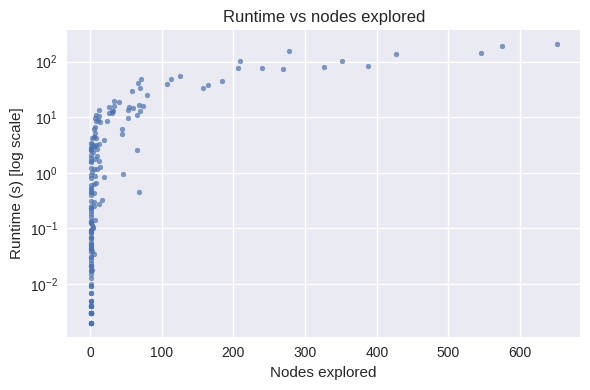

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_vs_nodes.png


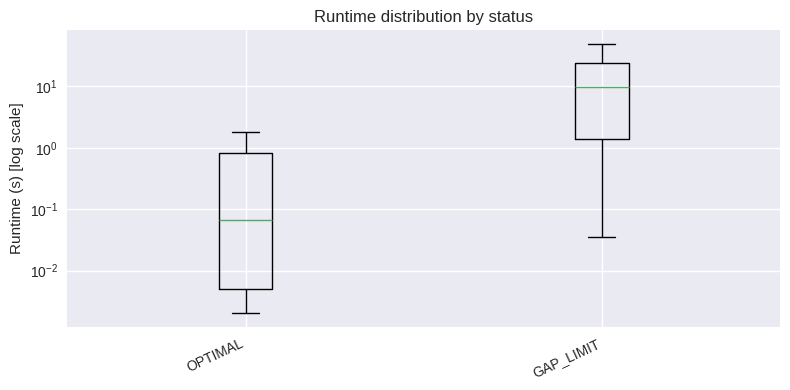

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_by_status.png


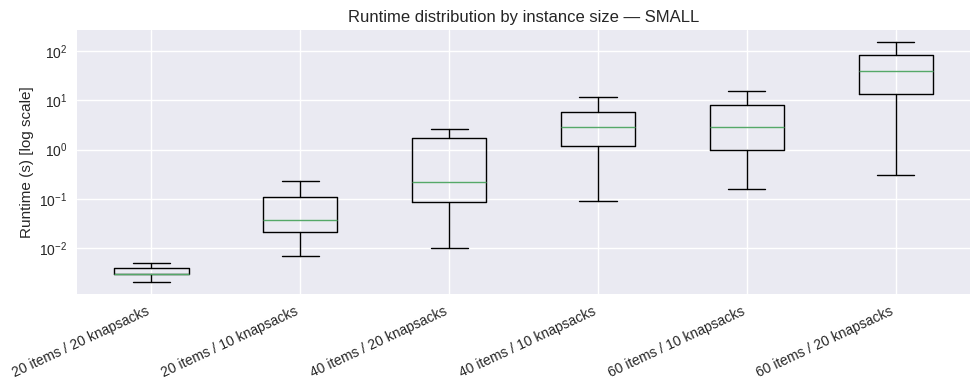

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_by_group_SMALL.png


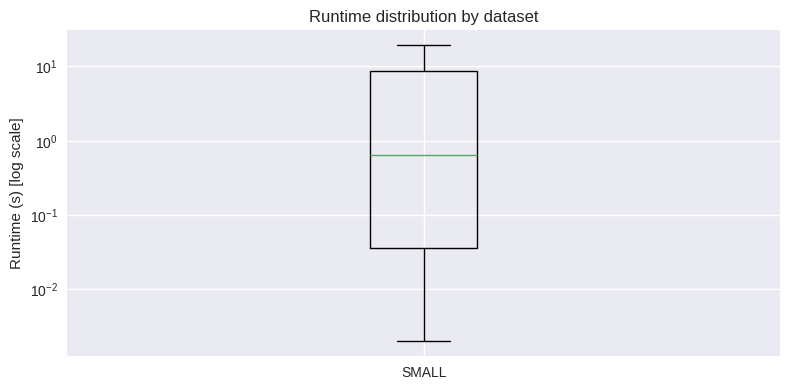

Saved: analysis_out/time-limit600_gap0.01_max-nodes1000/runtime_by_dataset.png
Wrote tables to analysis_out/time-limit600_gap0.01_max-nodes1000
=== Processing benchmark_results/time-limit600_gap0_max-nodes1000 ===


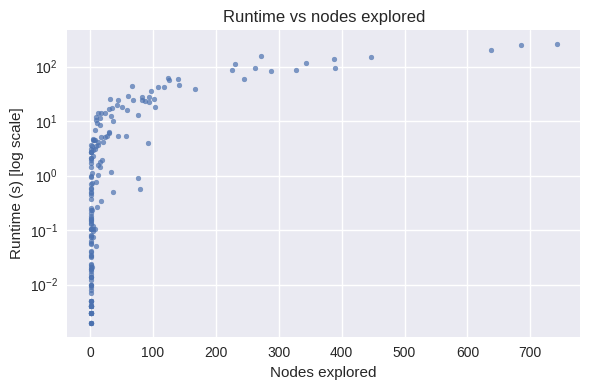

Saved: analysis_out/time-limit600_gap0_max-nodes1000/runtime_vs_nodes.png


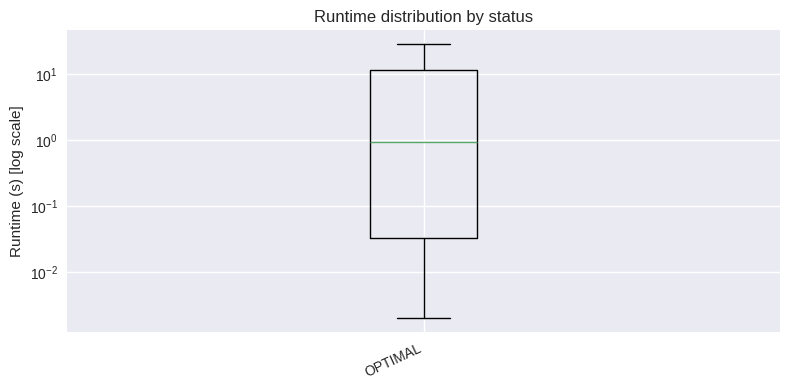

Saved: analysis_out/time-limit600_gap0_max-nodes1000/runtime_by_status.png


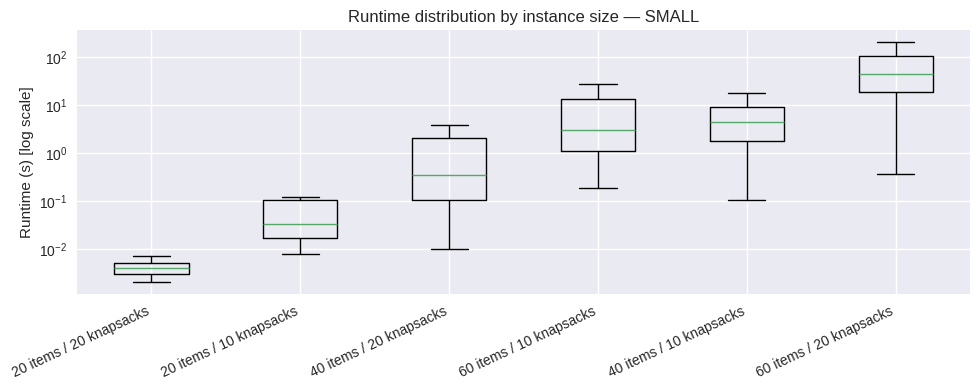

Saved: analysis_out/time-limit600_gap0_max-nodes1000/runtime_by_group_SMALL.png


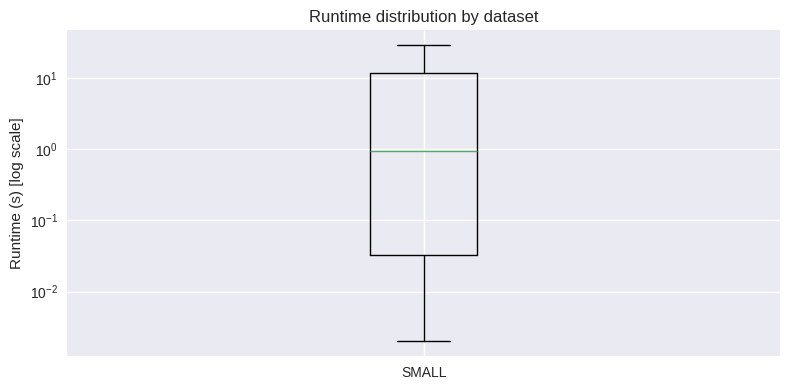

Saved: analysis_out/time-limit600_gap0_max-nodes1000/runtime_by_dataset.png
Wrote tables to analysis_out/time-limit600_gap0_max-nodes1000
=== Processing benchmark_results/time-limit600_gap0_max-nodes1000_max-instances10 ===


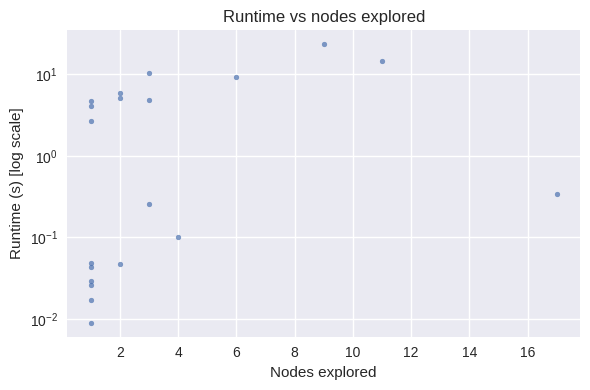

Saved: analysis_out/time-limit600_gap0_max-nodes1000_max-instances10/runtime_vs_nodes.png


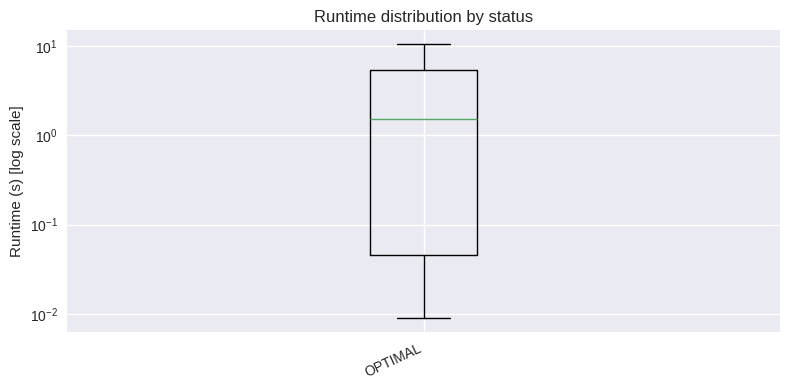

Saved: analysis_out/time-limit600_gap0_max-nodes1000_max-instances10/runtime_by_status.png


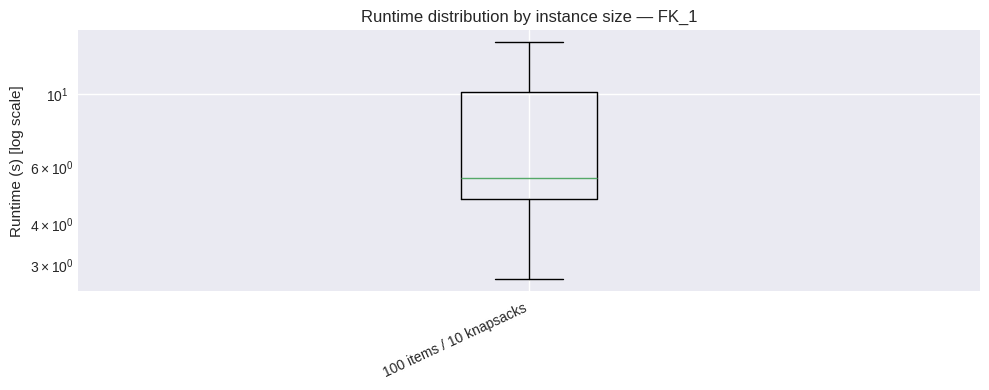

Saved: analysis_out/time-limit600_gap0_max-nodes1000_max-instances10/runtime_by_group_FK_1.png


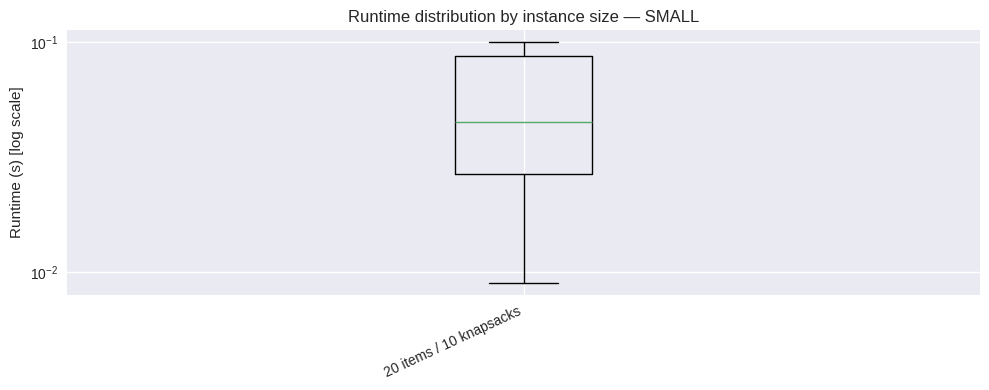

Saved: analysis_out/time-limit600_gap0_max-nodes1000_max-instances10/runtime_by_group_SMALL.png


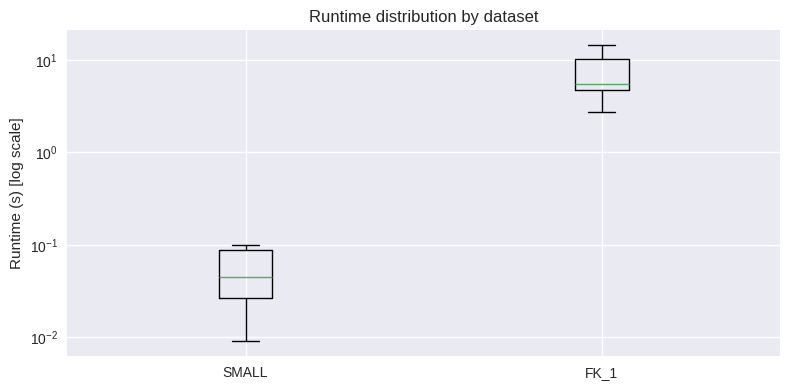

Saved: analysis_out/time-limit600_gap0_max-nodes1000_max-instances10/runtime_by_dataset.png
Wrote tables to analysis_out/time-limit600_gap0_max-nodes1000_max-instances10


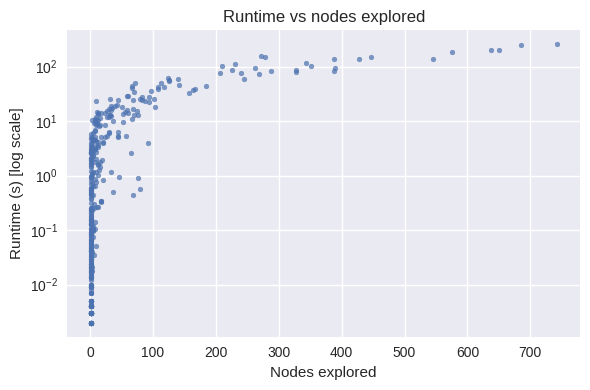

Saved: analysis_out/runtime_vs_nodes.png


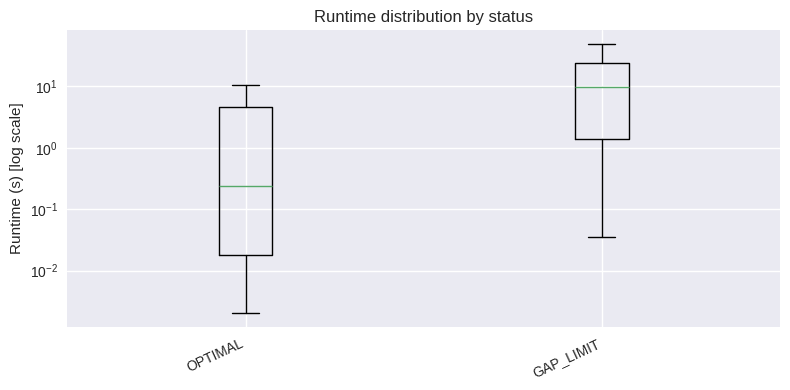

Saved: analysis_out/runtime_by_status.png


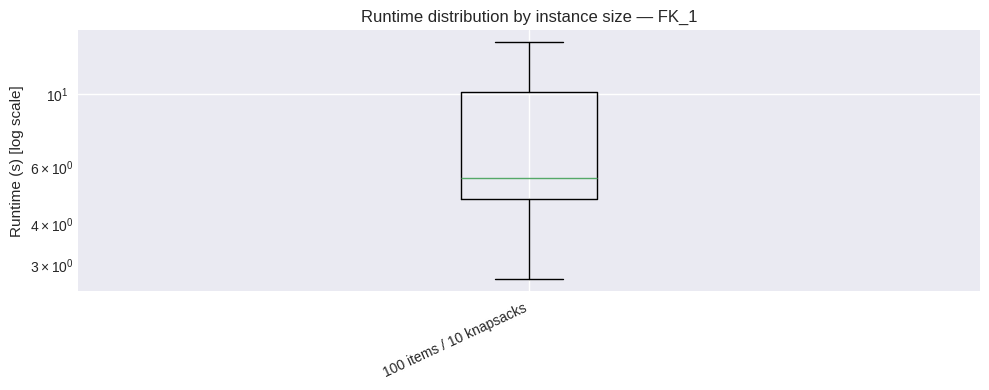

Saved: analysis_out/runtime_by_group_FK_1.png


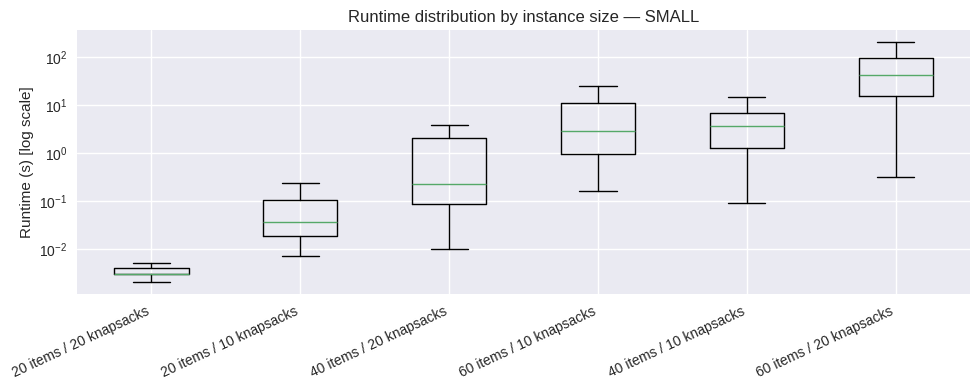

Saved: analysis_out/runtime_by_group_SMALL.png


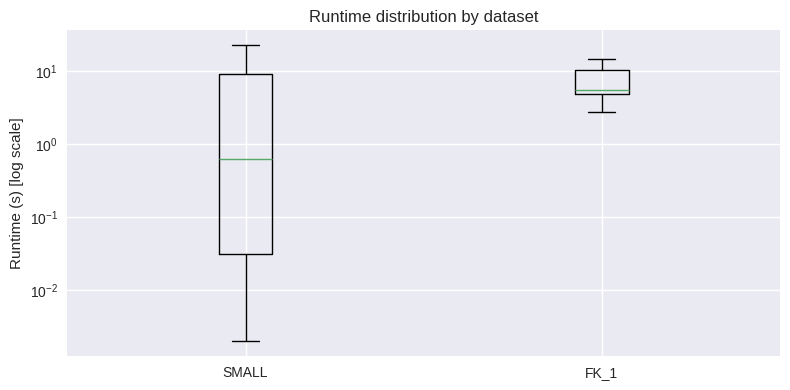

Saved: analysis_out/runtime_by_dataset.png
Wrote tables to analysis_out
Aggregated results written to analysis_out


In [101]:
# Run analysis for every benchmark run directory
all_runs: list[pd.DataFrame] = []

for rd in run_dirs:
    df_run = process_run(rd)
    if df_run is not None:
        all_runs.append(df_run)

# Optional aggregate across all runs
if all_runs:
    df = pd.concat(all_runs, ignore_index=True)
    dataset_names, status_summary, dataset_summary, dataset_status_summary, group_summary = summarize(df)

    aggregate_out = OUT_ROOT  # write aggregate to analysis_out/
    aggregate_out.mkdir(parents=True, exist_ok=True)

    plot_runtime_vs_nodes(df, aggregate_out)
    plot_runtime_by_status(df, status_summary, aggregate_out)
    plot_runtime_by_group(df, dataset_names, aggregate_out)
    plot_runtime_by_dataset(df, aggregate_out)
    write_tables(status_summary, dataset_summary, dataset_status_summary, group_summary, aggregate_out)
    print("Aggregated results written to", aggregate_out)
else:
    print("No runs processed; nothing to aggregate.")



## Run summaries
- Runs processed: 3 under `benchmark_results/`.
- Aggregate (all runs): 378 total instances; ~80% optimal (304/378) and 20% stopped at gap limit; median runtime 0.62s, p90 25.30s, max 256.66s; median nodes 3, mean ~33.
- Dataset breakdown:
  - SMALL: 368 runs; ~79.9% optimal; median 0.62s (p90 40.98s, max 256.66s); median 3 nodes, mean ~43.5.
  - FK_1 (sample 10): 10 runs; 100% optimal; median 5.54s (p90 15.35s, max 23.29s); median 2.5 nodes, mean 3.9.
- Per-run outputs live in `analysis_out/<run_dir>/`; aggregate plots/tables are in `analysis_out/`.

